# Dynamic Entry/Exit Game Homework
## Economics 600a - Yale University, Fall 2025
### Marek Chadim

This notebook solves a dynamic entry/exit game with Cournot competition using the Bajari-Benkard-Levin (BBL) estimation approach.

**References:**
- Bajari, Benkard, and Levin (2007). "Estimating Dynamic Models of Imperfect Competition." *Econometrica*.
- Ericson and Pakes (1995). "Markov-Perfect Industry Dynamics." *Review of Economic Studies*.
- Rust (1987). "Optimal Replacement of GMC Bus Engines." *Econometrica*.
- Hotz and Miller (1993). "Conditional Choice Probabilities and the Estimation of Dynamic Models." *Review of Economic Studies*.
- Ryan (2012). "The Costs of Environmental Regulation in a Concentrated Industry." *Econometrica*.
- Kawaguchi, K. (2024). *Empirical Industrial Organization*. Course materials.
- Ryan, S. (2024). "Estimating Dynamic Models Using Two-Step Methods." KIET Lectures.

## Model Setup

### Within-Period Competition

In each time period $t$, firms producing homogeneous products compete in a simultaneous-move Nash quantity-setting (Cournot) game. The market-level inverse demand curve is:

$$p_t = 10 - Q_t + x_t$$

where $Q_t$ is total quantity produced by all firms and $x_t$ is a demand shifter.

All firms have:
- Marginal cost: $mc = 0$
- Fixed cost of operation: $f = 5$ per period

### Demand Shifter Process

The demand shifter $x_t$ takes on three possible values $\{-5, 0, 5\}$ and evolves according to the first-order Markov transition matrix:

$$\Pr(x_{t+1}|x_t) = \begin{pmatrix}
0.6 & 0.2 & 0.2 \\
0.2 & 0.6 & 0.2 \\
0.2 & 0.2 & 0.6
\end{pmatrix}$$

### Exit Process

Each active firm receives a private, stochastic sell-off value:
$$\mu_{it} \sim N(\mu, \sigma_\mu^2)$$

assumed i.i.d. across firms and time. The value function for an active firm is:

$$V(N_t, x_t, \mu_{it}) = \max_{d_{it} \in \{0,1\}} \left\{ \mu_{it}, \pi(N_t, x_t) + 0.9 \mathbb{E}\left[V(N_{t+1}, x_{t+1}, \mu_{it+1}) | N_t, x_t, d_{it}=1\right] \right\}$$

where $d_{it} = 0$ if the firm exits and $d_{it} = 1$ if it remains.

### Entry Process

In each period, one potential entrant has a stochastic entry cost:
$$\gamma_{it} \sim N(\gamma, \sigma_\gamma^2)$$

The value function for a potential entrant is:

$$V^E(N_t, x_t, \gamma_{it}) = \max_{e_{it} \in \{0,1\}} \left\{ 0, -\gamma_{it} + 0.9 \mathbb{E}\left[V(N_{t+1}, x_{t+1}, \mu_{it+1}) | N_t, x_t, e_{it}=1\right] \right\}$$

### Equilibrium Concept

We focus on symmetric Markov-Perfect Nash Equilibria with cutoff form:

**Incumbent firm:**
$$d_{it} = \begin{cases}
0 & \text{if } \mu_{it} > \mu(N_t, x_t) \\
1 & \text{if } \mu_{it} \leq \mu(N_t, x_t)
\end{cases}$$

**Potential entrant:**
$$e_{it} = \begin{cases}
0 & \text{if } \gamma_{it} > \gamma(N_t, x_t) \\
1 & \text{if } \gamma_{it} \leq \gamma(N_t, x_t)
\end{cases}$$

The maximum number of firms is $N_{\max} = 5$, yielding 18 possible states.

In [26]:
# Import required libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import comb
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(2007)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Question 1: Nash Equilibrium Single-Period Profits

**Derive a formula for $\pi(N_t, x_t)$, the Nash equilibrium single-period profit per firm as a function of the number of firms and demand shifter.**

### Solution

In a Cournot game with $N$ identical firms, each firm $i$ chooses quantity $q_i$ to maximize:
$$\max_{q_i} (10 - Q + x)q_i - 0 \cdot q_i - 5$$

where $Q = \sum_{j=1}^N q_j$ is total quantity.

The first-order condition is:
$$10 - Q - q_i + x = 0$$

By symmetry, $q_i = q^*$ for all firms, so $Q = Nq^*$. Substituting:
$$10 - Nq^* - q^* + x = 0$$
$$q^* = \frac{10 + x}{N + 1}$$

The equilibrium price is:
$$p^* = 10 - Nq^* + x = 10 - N\frac{10 + x}{N + 1} + x = \frac{10 + x}{N + 1}$$

Therefore, per-firm profit is:
$$\boxed{\pi(N_t, x_t) = p^* \cdot q^* - 5 = \left[\frac{10 + x_t}{N_t + 1}\right]^2 - 5}$$

In [27]:
def compute_pi(N: int, x: float) -> float:
    """
    Compute Nash equilibrium single-period profit per firm.
    
    Formula: π(N, x) = [(10 + x)/(N + 1)]² - 5
    
    Parameters:
    -----------
    N : int
        Number of firms
    x : float
        Demand shifter
        
    Returns:
    --------
    float : Per-firm profit
    """
    if N == 0:
        return 0.0
    
    profit = ((10 + x) / (N + 1))**2 - 5
    return profit

# Demonstrate the profit function
print("Nash Equilibrium Profit Formula: π(N, x) = [(10 + x)/(N + 1)]² - 5\n")
print("Examples:")
print(f"{'N':>3} {'x':>4} {'π(N,x)':>10}")
print("-" * 20)
for N in range(1, 6):
    for x in [-5, 0, 5]:
        pi = compute_pi(N, x)
        print(f"{N:3d} {x:4d} {pi:10.4f}")

Nash Equilibrium Profit Formula: π(N, x) = [(10 + x)/(N + 1)]² - 5

Examples:
  N    x     π(N,x)
--------------------
  1   -5     1.2500
  1    0    20.0000
  1    5    51.2500
  2   -5    -2.2222
  2    0     6.1111
  2    5    20.0000
  3   -5    -3.4375
  3    0     1.2500
  3    5     9.0625
  4   -5    -4.0000
  4    0    -1.0000
  4    5     4.0000
  5   -5    -4.3056
  5    0    -2.2222
  5    5     1.2500


## Question 2: Intuition for Cutoff Equilibrium

**Why does a cutoff equilibrium make intuitive sense in this setup?**

### Solution

A cutoff equilibrium is intuitive for several reasons:

1. **Binary Decisions with Continuous Shocks**: Each firm makes a binary choice (stay/exit, enter/don't enter) based on a single continuous private shock ($\mu_{it}$ or $\gamma_{it}$). This naturally leads to a threshold rule.

2. **Monotonicity**: 
   - For incumbents: Higher exit values $\mu_{it}$ make exiting more attractive. There exists a threshold $\mu(N_t, x_t)$ such that firms with $\mu_{it} > \mu(N_t, x_t)$ prefer to exit.
   - For entrants: Higher entry costs $\gamma_{it}$ make entering less attractive. There exists a threshold $\gamma(N_t, x_t)$ such that firms with $\gamma_{it} > \gamma(N_t, x_t)$ prefer not to enter.

3. **Symmetric Information about State**: All firms observe the public state $(N_t, x_t)$ and face the same continuation value structure. Only the private shocks differ, so all firms use the same cutoff strategy.

4. **Additively Separable Payoffs**: The payoff structure is:
   - Exit: $\mu_{it}$ (immediate)
   - Stay: $\pi(N_t, x_t) + \beta \mathbb{E}[V_{t+1}]$ (independent of $\mu_{it}$)
   
   The comparison reduces to $\mu_{it}$ vs. $\pi(N_t, x_t) + \beta \mathbb{E}[V_{t+1}]$, defining a natural cutoff.

5. **Connection to Discrete Choice**: As Ryan (2024) notes, this is analogous to using probit models for entry/exit decisions in empirical work—agents with shocks above/below a threshold make different choices.

This cutoff characterization simplifies both the theoretical analysis and computational implementation, as we only need to track $\mu(N_t, x_t)$ and $\gamma(N_t, x_t)$ rather than full policy functions over the continuous shock space.

## Question 3: Interpretation of $\bar{V}(N_t, x_t)$

**Describe (at an intuitive level) what $\bar{V}(N_t, x_t)$ measures. How does this relate to the alternative specific value functions of Rust (1987)?**

### Solution

The function $\bar{V}(N_t, x_t)$ represents the **ex-ante expected value** for an incumbent firm in state $(N_t, x_t)$ **before observing the private exit value shock** $\mu_{it}$. Formally:

$$\bar{V}(N_t, x_t) = \int V(N_t, x_t, \mu_{it}) p(d\mu_{it})$$

where $p(d\mu_{it})$ is the density of the normal distribution $N(\mu, \sigma_\mu^2)$.

### Intuition

1. **Ex-Ante vs. Interim Value**: 
   - $V(N_t, x_t, \mu_{it})$ is the **interim** value function, conditional on observing both the public state and the private shock
   - $\bar{V}(N_t, x_t)$ is the **ex-ante** value function, conditional only on the public state

2. **Integration Over Private Information**: $\bar{V}(N_t, x_t)$ averages over all possible realizations of $\mu_{it}$, weighted by their probability. This captures the expected value of being an incumbent before learning whether you got a good or bad exit opportunity.

3. **Computational Role in BBL**: Following Ryan (2024), the value function can be written as:
   $$V(s) = \sum_{t=0}^{\infty} \beta^t \pi(s_t; a^*(s_t))$$
   
   The BBL insight is that we can **replace the value function with an infinite sum of payoffs**, using observed optimal actions $a^*(s_t)$ and empirical transitions from data, avoiding the need to solve the Bellman equation.

### Connection to Rust (1987)

In Rust's framework for dynamic discrete choice:

- **Alternative-Specific Value Functions**: $v_i(x, \epsilon)$ represents the value of choosing action $i$ in state $x$ with shock vector $\epsilon$

- **Integrated (Social Surplus) Value Function**: 
  $$V(x) = \mathbb{E}_{\epsilon}\left[\max_i v_i(x, \epsilon)\right]$$

Our $\bar{V}(N_t, x_t)$ is analogous to Rust's $V(x)$:
- Both integrate over the idiosyncratic shocks
- Both represent the expected value before observing choice-specific shocks
- Both separate the **structural component** (public state) from the **idiosyncratic component** (private shocks)

### Truncated Normal Formula

Given the cutoff $\mu(N_t, x_t)$, we can compute $\bar{V}(N_t, x_t)$ analytically:

$$\bar{V}(N_t, x_t) = \Pr(\text{exit}) \cdot \mathbb{E}[\mu_{it} | \mu_{it} > \mu(N_t, x_t)] + \Pr(\text{stay}) \cdot \mu(N_t, x_t)$$

where the conditional expectation uses the truncated normal distribution:
$$\mathbb{E}[\mu_{it} | \mu_{it} > \mu(N_t, x_t)] = \mu + \sigma_\mu \frac{\phi(z)}{1 - \Phi(z)}$$

with $z = (\mu(N_t, x_t) - \mu)/\sigma_\mu$ and $\phi, \Phi$ denoting the standard normal PDF and CDF (the Mills ratio).

## Implementation: Dynamic Entry/Exit Game Class

Following the two-step methodology of Bajari, Benkard, and Levin (2007):

### Step 1: Estimate Policy Functions
- From data, estimate $\hat{d}(N_t, x_t)$ = probability incumbent stays
- From data, estimate $\hat{e}(N_t, x_t)$ = probability entrant enters
- These are the **conditional choice probabilities (CCPs)**

### Step 2: Recover Structural Parameters
- Given CCPs, use forward simulation to compute value functions
- Find parameters $\theta = (\gamma, \sigma_\gamma, \mu, \sigma_\mu)$ that rationalize observed behavior
- Key inequality from Ryan (2024):
  $$V(s; a^*(s); \theta) \geq V(s; a'(s); \theta), \quad \forall a'(s) \neq a^*(s)$$

Under optimizing behavior, agents can't deviate from observed strategy and do better.

In [28]:
def binom_pmf(k: int, n: int, p: float) -> float:
    """Binomial PMF: P(X = k) where X ~ Binomial(n, p)"""
    if k < 0 or k > n:
        return 0.0
    if n == 0:
        return 1.0 if k == 0 else 0.0
    return comb(n, k, exact=True) * (p**k) * ((1-p)**(n-k))


class DynamicEntryExitGame:
    """
    Solver for dynamic entry/exit game with Cournot competition.
    
    Based on:
    - Ericson & Pakes (1995) framework
    - BBL (2007) two-step estimation
    - Hotz & Miller (1993) CCP approach
    """
    
    def __init__(self, gamma=5, sigma_gamma=np.sqrt(5), mu=5, sigma_mu=np.sqrt(5)):
        """
        Initialize model parameters.
        
        Parameters:
        -----------
        gamma : float
            Mean entry cost
        sigma_gamma : float
            Std dev of entry cost
        mu : float
            Mean exit value
        sigma_mu : float
            Std dev of exit value
        """
        self.gamma = gamma
        self.sigma_gamma = sigma_gamma
        self.mu = mu
        self.sigma_mu = sigma_mu
        
        # Model primitives
        self.beta = 0.9  # Discount factor
        self.N_max = 5   # Maximum number of firms
        self.x_values = np.array([-5, 0, 5])  # Demand shifter values
        
        # Transition matrix for demand shifter
        self.P_x = np.array([
            [0.6, 0.2, 0.2],
            [0.2, 0.6, 0.2],
            [0.2, 0.2, 0.6]
        ])
        
        # State space: N_t in {0,1,2,3,4,5}, x_t in {-5,0,5}
        self.states = [(n, x) for n in range(self.N_max + 1) 
                       for x in self.x_values]
        
        # Initialize equilibrium objects
        self.mu_cutoff = {}
        self.gamma_cutoff = {}
        self.V_bar = {}
        
    def compute_pi(self, N: int, x: float) -> float:
        """Compute Nash equilibrium single-period profit per firm."""
        if N == 0:
            return 0.0
        profit = ((10 + x) / (N + 1))**2 - 5
        return profit
    
    def compute_transition_prob(self, N: int, x: float, decision: str) -> np.ndarray:
        """
        Compute transition probabilities for number of firms.
        
        Parameters:
        -----------
        N : int
            Current number of firms
        x : float
            Current demand shifter
        decision : str
            'd' for incumbent stays (d_it=1), 'e' for entrant enters (e_it=1)
            
        Returns:
        --------
        np.ndarray : Probability distribution over N_{t+1} in {0,1,2,3,4,5}
        """
        prob = np.zeros(self.N_max + 1)
        
        if decision == 'd':  # Incumbent stays (conditioning on d_it=1)
            if N == 0:
                prob[0] = 1.0
                return prob
                
            # Probability each OTHER incumbent stays
            mu_cut = self.mu_cutoff.get((N, x), self.mu)
            p_stay = norm.cdf((mu_cut - self.mu) / self.sigma_mu)
            
            # Distribution over number of OTHER firms that stay
            for n_others_stay in range(N):
                prob_n_others = binom_pmf(n_others_stay, N - 1, p_stay)
                n_stay_total = n_others_stay + 1  # Include the conditioned firm
                
                # Add potential entrant if room
                if n_stay_total < self.N_max:
                    gamma_cut = self.gamma_cutoff.get((n_stay_total, x), self.gamma)
                    p_enter = norm.cdf((gamma_cut - self.gamma) / self.sigma_gamma)
                    prob[n_stay_total] += prob_n_others * (1 - p_enter)
                    prob[n_stay_total + 1] += prob_n_others * p_enter
                else:
                    prob[n_stay_total] += prob_n_others
                    
        else:  # Entrant enters (e_it = 1)
            if N >= self.N_max:
                prob[N] = 1.0
                return prob
                
            # Probability each incumbent stays
            if N > 0:
                mu_cut = self.mu_cutoff.get((N, x), self.mu)
                p_stay = norm.cdf((mu_cut - self.mu) / self.sigma_mu)
            else:
                p_stay = 0
            
            # Distribution over staying incumbents
            for n_stay in range(N + 1):
                prob_n_stay = binom_pmf(n_stay, N, p_stay)
                # Add the entrant (enters next period)
                n_next = min(n_stay + 1, self.N_max)
                prob[n_next] += prob_n_stay
                    
        return prob

print("Dynamic Entry/Exit Game class defined successfully!")

Dynamic Entry/Exit Game class defined successfully!


## Question 4: Solving for Equilibrium

**Use the iterative algorithm to solve for equilibrium with parameters: $\gamma = 5$, $\sigma_\gamma^2 = 5$, $\mu = 5$, $\sigma_\mu^2 = 5$.**

### Algorithm (from homework):

1. **Guess** $\mu(N_t, x_t)$, $\gamma(N_t, x_t)$, and $\bar{V}(N_t, x_t)$

2. Using $\mu(N_t, x_t)$ and $\gamma(N_t, x_t)$, **compute transition matrices**:
   - $\Pr(N_{t+1}|N_t, x_t, d_{it}=1)$
   - $\Pr(N_{t+1}|N_t, x_t, e_{it}=1)$

3. **Compute continuation values**:
   $$\Psi_1(N_t, x_t) = 0.9 \sum_{N_{t+1}} \sum_{x_{t+1}} \bar{V}(N_{t+1}, x_{t+1}) \Pr(x_{t+1}|x_t) \Pr(N_{t+1}|N_t, x_t, d_{it}=1)$$
   $$\Psi_2(N_t, x_t) = 0.9 \sum_{N_{t+1}} \sum_{x_{t+1}} \bar{V}(N_{t+1}, x_{t+1}) \Pr(x_{t+1}|x_t) \Pr(N_{t+1}|N_t, x_t, e_{it}=1)$$

4. **Update cutoffs**:
   $\mu'(N_t, x_t) = \pi(N_t, x_t) + \Psi_1(N_t, x_t)$
   $\gamma'(N_t, x_t) = \Psi_2(N_t, x_t)$

5. **Update $\bar{V}'(N_t, x_t)$** using truncated normal formula:
   $\bar{V}'(N_t, x_t) = \left[1 - \Phi\left(\frac{\mu'(N_t,x_t) - \mu}{\sigma_\mu}\right)\right] \left[\mu + \sigma_\mu \frac{\phi(z)}{1-\Phi(z)}\right] + \Phi\left(\frac{\mu'(N_t,x_t) - \mu}{\sigma_\mu}\right) \mu'(N_t,x_t)$

6. **Iterate** until convergence

In [ ]:
def solve_equilibrium(self, max_iter=3000, tol=1e-8, verbose=False, damping=0.5):
    """Solve MPE using value function iteration with damping for stability"""
    # Initialize with reasonable values
    for (N, x) in self.states:
        if N > 0:
            pi = self.compute_pi(N, x)
            self.mu_cutoff[(N, x)] = max(pi, 0) + self.mu
            self.V_bar[(N, x)] = max(pi / (1 - self.beta), self.mu)
        if N < self.N_max:
            self.gamma_cutoff[(N, x)] = self.gamma
    
    for it in range(max_iter):
        mu_old = self.mu_cutoff.copy()
        gamma_old = self.gamma_cutoff.copy()
        V_old = self.V_bar.copy()
        Psi_1, Psi_2 = {}, {}
        
        # Compute continuation values
        for (N, x) in self.states:
            x_idx = np.where(self.x_values == x)[0][0]
            if N > 0:
                val = 0.0
                for x_idx_next, x_next in enumerate(self.x_values):
                    trans = self.compute_transition_prob(N, x, 'd')
                    for N_next in range(self.N_max + 1):
                        if N_next > 0 and trans[N_next] > 1e-10:
                            val += self.beta * self.P_x[x_idx, x_idx_next] * trans[N_next] * self.V_bar.get((N_next, x_next), 0)
                Psi_1[(N, x)] = val
            
            if N < self.N_max:
                val = 0.0
                for x_idx_next, x_next in enumerate(self.x_values):
                    trans = self.compute_transition_prob(N, x, 'e')
                    for N_next in range(self.N_max + 1):
                        if N_next > 0 and trans[N_next] > 1e-10:
                            val += self.beta * self.P_x[x_idx, x_idx_next] * trans[N_next] * self.V_bar.get((N_next, x_next), 0)
                Psi_2[(N, x)] = val
        
        # Update cutoffs with damping
        for (N, x) in self.states:
            if N > 0:
                mu_new = self.compute_pi(N, x) + Psi_1.get((N, x), 0)
                self.mu_cutoff[(N, x)] = damping * mu_new + (1 - damping) * mu_old[(N, x)]
            if N < self.N_max:
                gamma_new = Psi_2.get((N, x), 0)
                self.gamma_cutoff[(N, x)] = damping * gamma_new + (1 - damping) * gamma_old[(N, x)]
        
        # Update V̄ using truncated normal
        for (N, x) in self.states:
            if N > 0:
                thresh = self.mu_cutoff[(N, x)]
                z = (thresh - self.mu) / self.sigma_mu
                prob_stay = norm.cdf(z)
                
                if prob_stay < 0.9999:
                    mills = norm.pdf(z) / (1 - norm.cdf(z))
                    E_mu_exit = self.mu + self.sigma_mu * mills
                else:
                    E_mu_exit = thresh
                
                V_new = prob_stay * thresh + (1 - prob_stay) * E_mu_exit
                self.V_bar[(N, x)] = damping * V_new + (1 - damping) * V_old[(N, x)]
        
        # Check convergence
        diff = max(
            max(abs(self.mu_cutoff[k] - mu_old[k]) for k in mu_old),
            max(abs(self.gamma_cutoff[k] - gamma_old[k]) for k in gamma_old),
            max(abs(self.V_bar[k] - V_old[k]) for k in V_old)
        )
        
        if verbose and it % 200 == 0:
            print(f"  Iter {it}: diff={diff:.6e}")
        if diff < tol:
            if verbose:
                print(f"  Converged in {it+1} iterations")
            return True
    
    if verbose:
        print(f"  Max iterations reached. Final diff: {diff:.6e}")
    return diff < tol * 100  # Accept if reasonably close

Solving for equilibrium...
Parameters: γ=5.00, σ_γ=2.24, μ=5.00, σ_μ=2.24
Iteration 0: max difference = 2.657639e+02
Iteration 100: max difference = 2.740452e-02
Iteration 200: max difference = 1.280376e-04
Iteration 100: max difference = 2.740452e-02
Iteration 200: max difference = 1.280376e-04
Iteration 300: max difference = 1.074103e-06
Iteration 400: max difference = 1.713453e-08

Converged in 415 iterations!
Iteration 300: max difference = 1.074103e-06
Iteration 400: max difference = 1.713453e-08

Converged in 415 iterations!


## Question 5: Multiple Equilibria

**Try resolving for equilibrium starting with 5 different initial guesses. Do you find evidence of multiple equilibria?**

In [41]:
# Test for multiple equilibria with different initial guesses
def test_multiple_equilibria(num_guesses=5):
    """
    Test for multiple equilibria by solving from different initial conditions.
    """
    equilibria = []
    initial_guesses = []
    
    for i in range(num_guesses):
        game_test = DynamicEntryExitGame(gamma=5, sigma_gamma=np.sqrt(5), 
                                         mu=5, sigma_mu=np.sqrt(5))
        
        # Different initializations
        multiplier = 0.5 + i * 0.25
        gamma_offset = -2.0 + i * 1.0
        initial_guesses.append({
            'guess': i+1,
            'multiplier': multiplier,
            'gamma_offset': gamma_offset
        })
        
        for (N, x) in game_test.states:
            if N > 0:
                pi_val = game_test.compute_pi(N, x)
                game_test.mu_cutoff[(N, x)] = pi_val * multiplier
                game_test.V_bar[(N, x)] = pi_val * multiplier / (1 - game_test.beta)
            if N < game_test.N_max:
                game_test.gamma_cutoff[(N, x)] = gamma_offset
        
        # Solve
        converged = game_test.solve_equilibrium(max_iter=2000, tol=1e-8, verbose=False)
        
        if converged:
            eq_values = {
                'mu': game_test.mu_cutoff.copy(),
                'gamma': game_test.gamma_cutoff.copy(),
                'V_bar': game_test.V_bar.copy()
            }
            equilibria.append(eq_values)
    
    # Report initial guesses and results
    print("Initial Guesses and Equilibrium Results:")
    print("=" * 60)
    
    # Initial guesses table
    print("\nInitial Guesses:")
    ig_data = []
    for ig in initial_guesses:
        ig_data.append({
            'Guess': ig['guess'],
            'Multiplier': f"{ig['multiplier']:.2f}",
            'γ_Offset': f"{ig['gamma_offset']:.1f}"
        })
    df_ig = pd.DataFrame(ig_data)
    print(df_ig.to_string(index=False))
    
    # Equilibrium results table (key state: N=3, x=0)
    print("\nResulting Equilibrium Values at (N=3, x=0):")
    eq_data = []
    for i, eq in enumerate(equilibria):
        eq_data.append({
            'Guess': i+1,
            'μ(3,0)': f"{eq['mu'].get((3, 0), np.nan):.4f}",
            'γ(3,0)': f"{eq['gamma'].get((3, 0), np.nan):.4f}",
            'V̄(3,0)': f"{eq['V_bar'].get((3, 0), np.nan):.4f}"
        })
    df_eq = pd.DataFrame(eq_data)
    print(df_eq.to_string(index=False))
    
    # Summary
    n_converged = len(equilibria)
    if n_converged == num_guesses:
        # Check if all same
        max_diff = 0
        for key in equilibria[0]['mu']:
            for eq in equilibria[1:]:
                if key in eq['mu']:
                    diff = abs(equilibria[0]['mu'][key] - eq['mu'][key])
                    max_diff = max(max_diff, diff)
        
        if max_diff < 1e-4:
            print("\n No evidence of multiple equilibria")
        else:
            print(f"\n Evidence of multiple equilibria (max diff: {max_diff:.6e})")
    else:
        print(f"\n✗ Only {n_converged}/{num_guesses} guesses converged")
    
    return equilibria

# Run test
equilibria = test_multiple_equilibria(num_guesses=5)

Initial Guesses and Equilibrium Results:

Initial Guesses:
 Guess Multiplier γ_Offset
     1       0.50     -2.0
     2       0.75     -1.0
     3       1.00      0.0
     4       1.25      1.0
     5       1.50      2.0

Resulting Equilibrium Values at (N=3, x=0):
 Guess μ(3,0) γ(3,0) V̄(3,0)
     1 8.4730 6.9798  8.5310
     2 8.4730 6.9798  8.5310
     3 8.4730 6.9798  8.5310
     4 8.4730 6.9798  8.5310
     5 8.4730 6.9798  8.5310

 No evidence of multiple equilibria


## Question 6: Equilibrium Values at (N=3, x=0)

**Report the values $\mu(3, 0)$, $\gamma(3, 0)$, $\bar{V}(3, 0)$, and $V(3, 0, -2)$.**

Question 6: Equilibrium Values at (N=3, x=0)

μ(3, 0)  = 8.472981
γ(3, 0)  = 6.979849
V̄(3, 0)  = 8.530970

V(3, 0, -2):
  Given μ_it = -2.0 and μ(3,0) = 8.4730
  Since μ_it ≤ μ(3,0), firm STAYS
  V(3, 0, -2) = 8.472981 (continuation value)

Additional information:
  π(3, 0) = 1.250000
  Firms stay if they value continuation > exit opportunity


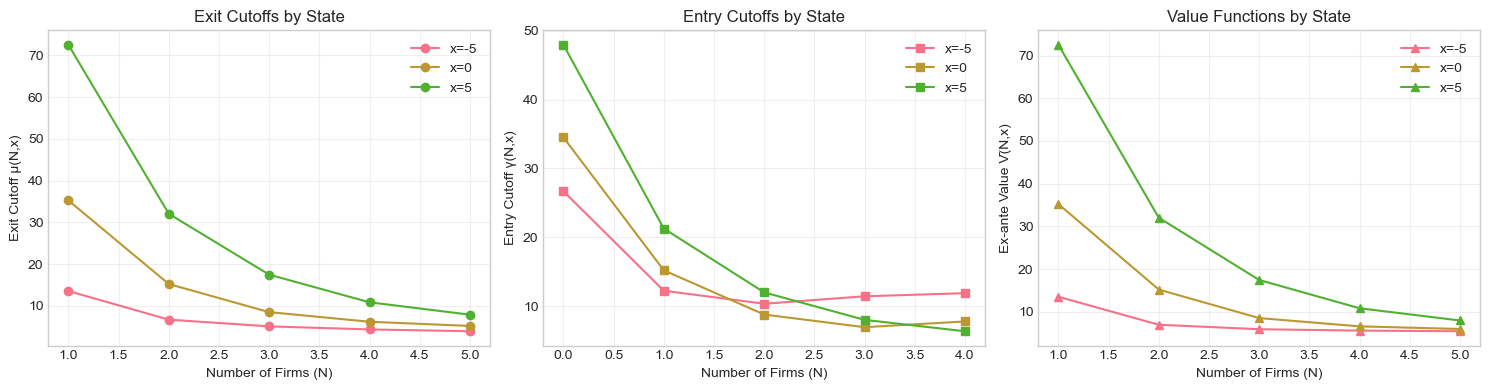

In [31]:
# Question 6: Report equilibrium values
print("="*70)
print("Question 6: Equilibrium Values at (N=3, x=0)")
print("="*70)

N_query, x_query = 3, 0

mu_30 = game.mu_cutoff.get((N_query, x_query), np.nan)
gamma_30 = game.gamma_cutoff.get((N_query, x_query), np.nan)
V_bar_30 = game.V_bar.get((N_query, x_query), np.nan)

print(f"\nμ(3, 0)  = {mu_30:.6f}")
print(f"γ(3, 0)  = {gamma_30:.6f}")
print(f"V̄(3, 0)  = {V_bar_30:.6f}")

# For V(3, 0, -2): Value for specific μ_it = -2
mu_specific = -2.0
print(f"\nV(3, 0, -2):")
print(f"  Given μ_it = {mu_specific:.1f} and μ(3,0) = {mu_30:.4f}")

if mu_specific > mu_30:
    print(f"  Since μ_it > μ(3,0), firm EXITS")
    print(f"  V(3, 0, -2) = {mu_specific:.6f} (immediate exit payoff)")
else:
    print(f"  Since μ_it ≤ μ(3,0), firm STAYS")
    print(f"  V(3, 0, -2) = {mu_30:.6f} (continuation value)")

# Display profit function at this state
pi_30 = game.compute_pi(3, 0)
print(f"\nAdditional information:")
print(f"  π(3, 0) = {pi_30:.6f}")
print(f"  Firms stay if they value continuation > exit opportunity")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: μ cutoffs across states
N_vals = []
x_vals_plot = []
mu_vals = []
for (N, x) in game.states:
    if N > 0:
        N_vals.append(N)
        x_vals_plot.append(x)
        mu_vals.append(game.mu_cutoff.get((N, x), np.nan))

df_plot = pd.DataFrame({'N': N_vals, 'x': x_vals_plot, 'mu': mu_vals})
for x_val in [-5, 0, 5]:
    df_x = df_plot[df_plot['x'] == x_val]
    axes[0].plot(df_x['N'], df_x['mu'], marker='o', label=f'x={x_val}')
axes[0].set_xlabel('Number of Firms (N)')
axes[0].set_ylabel('Exit Cutoff μ(N,x)')
axes[0].set_title('Exit Cutoffs by State')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: γ cutoffs across states
N_vals_g = []
x_vals_g = []
gamma_vals = []
for (N, x) in game.states:
    if N < game.N_max:
        N_vals_g.append(N)
        x_vals_g.append(x)
        gamma_vals.append(game.gamma_cutoff.get((N, x), np.nan))

df_plot_g = pd.DataFrame({'N': N_vals_g, 'x': x_vals_g, 'gamma': gamma_vals})
for x_val in [-5, 0, 5]:
    df_x = df_plot_g[df_plot_g['x'] == x_val]
    axes[1].plot(df_x['N'], df_x['gamma'], marker='s', label=f'x={x_val}')
axes[1].set_xlabel('Number of Firms (N)')
axes[1].set_ylabel('Entry Cutoff γ(N,x)')
axes[1].set_title('Entry Cutoffs by State')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: V̄ values
N_vals_v = []
x_vals_v = []
V_vals = []
for (N, x) in game.states:
    if N > 0:
        N_vals_v.append(N)
        x_vals_v.append(x)
        V_vals.append(game.V_bar.get((N, x), np.nan))

df_plot_v = pd.DataFrame({'N': N_vals_v, 'x': x_vals_v, 'V_bar': V_vals})
for x_val in [-5, 0, 5]:
    df_x = df_plot_v[df_plot_v['x'] == x_val]
    axes[2].plot(df_x['N'], df_x['V_bar'], marker='^', label=f'x={x_val}')
axes[2].set_xlabel('Number of Firms (N)')
axes[2].set_ylabel('Ex-ante Value V̄(N,x)')
axes[2].set_title('Value Functions by State')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Question 7: Market Simulation

**Starting with 0 firms and $x_t = 0$, simulate the market for 10,000 periods. What is the average number of firms?**

Question 7: Market Simulation

Simulation Results (T=10,000 periods):
  Starting state: N=0, x=0

  Average number of firms: 3.446
  Std deviation:           1.098
  Median number of firms:  3.0

  Distribution of firms:
    N=1:   352 periods ( 3.52%)
    N=2:  1703 periods (17.03%)
    N=3:  3113 periods (31.13%)
    N=4:  2794 periods (27.94%)
    N=5:  2038 periods (20.38%)

  Total entries: 8515
  Total exits:   8512
  Net change:    3


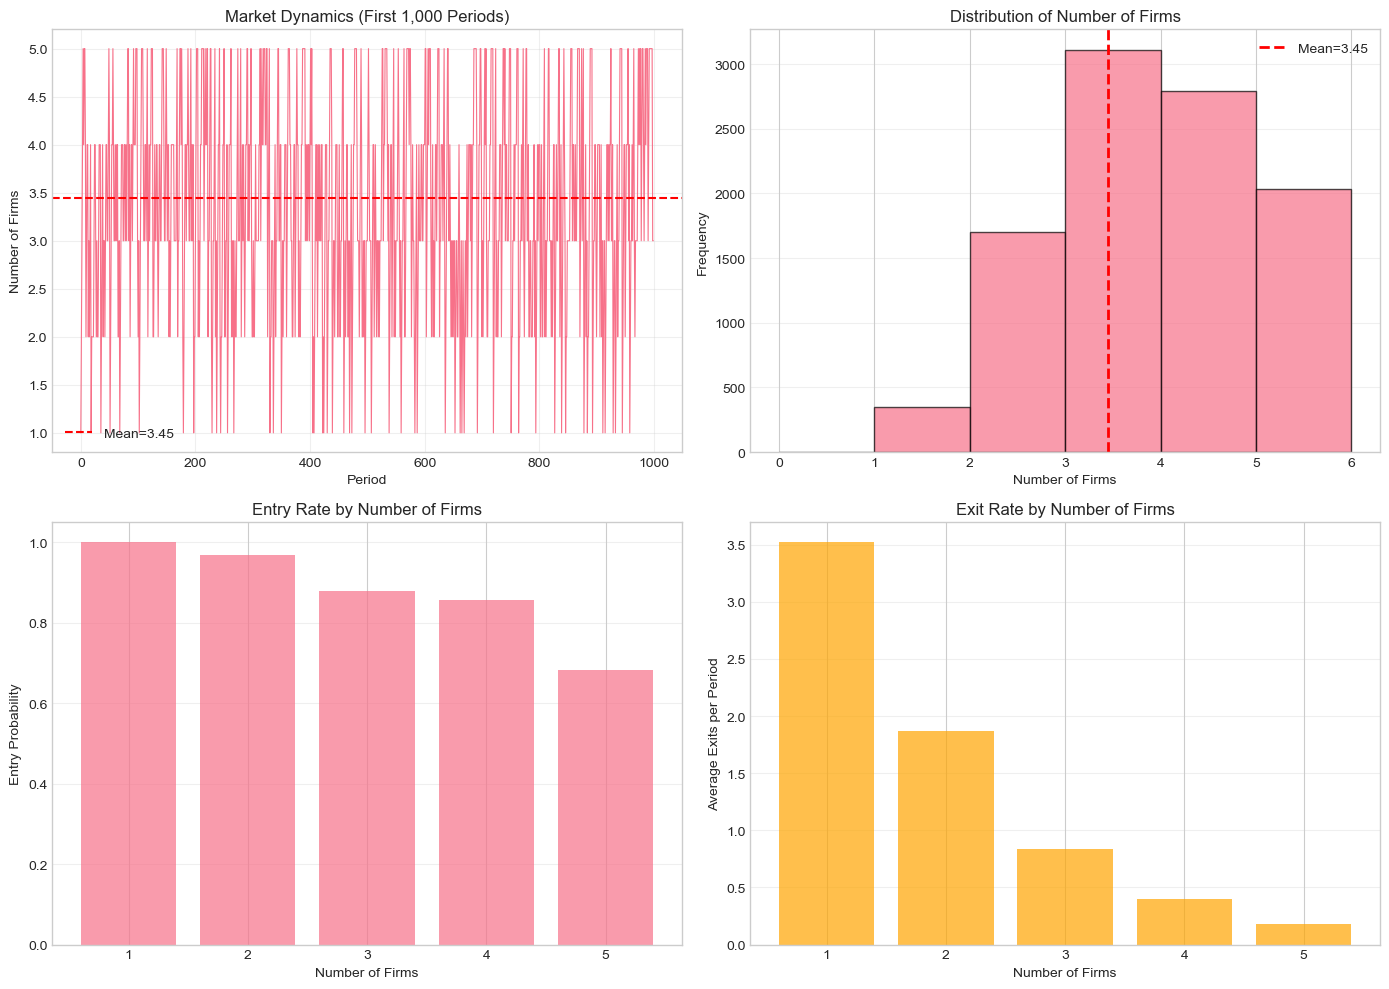


✓ Simulated data saved for BBL estimation


In [32]:
def simulate_market(self, N_init=0, x_init=0, T=10000, seed=None):
    """
    Question 7: Simulate market dynamics.
    
    Parameters:
    -----------
    N_init : int
        Initial number of firms
    x_init : float
        Initial demand shifter
    T : int
        Number of periods to simulate
    seed : int
        Random seed
        
    Returns:
    --------
    pd.DataFrame : Simulated data with columns ['period', 'N', 'x', 'entry', 'exits']
    """
    if seed is not None:
        np.random.seed(seed)
    
    data = []
    N_t = N_init
    x_t = x_init
    
    for t in range(T):
        N_initial = N_t  # Record N before exits for CCP estimation
        
        # Exit decisions for incumbents
        n_exits = 0
        if N_t > 0:
            mu_cut = self.mu_cutoff.get((N_t, x_t), self.mu)
            # Draw private exit values
            mu_draws = np.random.normal(self.mu, self.sigma_mu, N_t)
            # Firms stay if μ_it ≤ μ(N_t, x_t)
            stay = mu_draws <= mu_cut
            n_exits = N_t - np.sum(stay)
            N_t = int(np.sum(stay))
        
        # Entry decision
        entry = 0
        if N_t < self.N_max:
            gamma_cut = self.gamma_cutoff.get((N_t, x_t), self.gamma)
            # Draw private entry cost
            gamma_draw = np.random.normal(self.gamma, self.sigma_gamma)
            # Entrant enters if γ_it ≤ γ(N_t, x_t)
            if gamma_draw <= gamma_cut:
                N_t += 1
                entry = 1
        
        # Record state
        data.append({
            'period': t, 
            'N_initial': N_initial,
            'N': N_t, 
            'x': x_t,
            'entry': entry,
            'exits': n_exits
        })
        
        # Demand shifter transition
        x_idx = np.where(self.x_values == x_t)[0][0]
        x_idx_next = np.random.choice(len(self.x_values), 
                                     p=self.P_x[x_idx, :])
        x_t = self.x_values[x_idx_next]
    
    return pd.DataFrame(data)

# Add method to class
DynamicEntryExitGame.simulate_market = simulate_market

# Simulate market
print("="*70)
print("Question 7: Market Simulation")
print("="*70)

df_sim = game.simulate_market(N_init=0, x_init=0, T=10000, seed=1995)

# Calculate statistics
avg_firms = df_sim['N'].mean()
std_firms = df_sim['N'].std()
median_firms = df_sim['N'].median()

print(f"\nSimulation Results (T=10,000 periods):")
print(f"  Starting state: N=0, x=0")
print(f"\n  Average number of firms: {avg_firms:.3f}")
print(f"  Std deviation:           {std_firms:.3f}")
print(f"  Median number of firms:  {median_firms:.1f}")

print(f"\n  Distribution of firms:")
firm_dist = df_sim['N'].value_counts().sort_index()
for n, count in firm_dist.items():
    pct = 100 * count / len(df_sim)
    print(f"    N={n}: {count:5d} periods ({pct:5.2f}%)")

# Entry and exit statistics
total_entries = df_sim['entry'].sum()
total_exits = df_sim['exits'].sum()
print(f"\n  Total entries: {total_entries}")
print(f"  Total exits:   {total_exits}")
print(f"  Net change:    {total_entries - total_exits}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Time series of N
axes[0, 0].plot(df_sim['period'][:1000], df_sim['N'][:1000], linewidth=0.8)
axes[0, 0].axhline(y=avg_firms, color='r', linestyle='--', label=f'Mean={avg_firms:.2f}')
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Number of Firms')
axes[0, 0].set_title('Market Dynamics (First 1,000 Periods)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram of N
axes[0, 1].hist(df_sim['N'], bins=range(0, 7), edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=avg_firms, color='r', linestyle='--', linewidth=2, label=f'Mean={avg_firms:.2f}')
axes[0, 1].set_xlabel('Number of Firms')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Number of Firms')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Entry and exit rates by state
entry_by_N = df_sim.groupby('N')['entry'].mean()
axes[1, 0].bar(entry_by_N.index, entry_by_N.values, alpha=0.7)
axes[1, 0].set_xlabel('Number of Firms')
axes[1, 0].set_ylabel('Entry Probability')
axes[1, 0].set_title('Entry Rate by Number of Firms')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Average exits by state
exits_by_N = df_sim[df_sim['N'] > 0].groupby('N')['exits'].mean()
axes[1, 1].bar(exits_by_N.index, exits_by_N.values, alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Number of Firms')
axes[1, 1].set_ylabel('Average Exits per Period')
axes[1, 1].set_title('Exit Rate by Number of Firms')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Save simulated data for BBL estimation
game.df_sim = df_sim
print(f"\n✓ Simulated data saved for BBL estimation")

## Question 8: Entry Tax Counterfactual

**Suppose the government implements a 5 unit entry tax. What happens to the average number of firms? Can you answer this if there are multiple equilibria?**

### Solution

An entry tax of 5 units shifts the entry cost distribution: $\gamma_{it} + 5 \sim N(\gamma + 5, \sigma_\gamma^2)$.

This means we need to resolve the equilibrium with $\gamma' = \gamma + 5 = 10$.

Question 8: Entry Tax Counterfactual

Solving equilibrium with 5-unit entry tax...
New entry cost mean: γ = 10
Solving for equilibrium...
Parameters: γ=10.00, σ_γ=2.24, μ=5.00, σ_μ=2.24
Iteration 0: max difference = 2.680048e+02
Iteration 100: max difference = 2.517362e-02
Iteration 200: max difference = 5.594304e-04
Iteration 300: max difference = 2.743752e-05
Iteration 400: max difference = 1.163192e-06
Iteration 400: max difference = 1.163192e-06
Iteration 500: max difference = 4.313985e-08

Converged in 545 iterations!
Iteration 500: max difference = 4.313985e-08

Converged in 545 iterations!


Results Comparison

  Baseline (no tax):
    Average firms: 3.446

  With 5-unit entry tax:
    Average firms: 3.342

  Effect of tax:
    Change: -0.104 firms (-3.0%)


Results Comparison

  Baseline (no tax):
    Average firms: 3.446

  With 5-unit entry tax:
    Average firms: 3.342

  Effect of tax:
    Change: -0.104 firms (-3.0%)


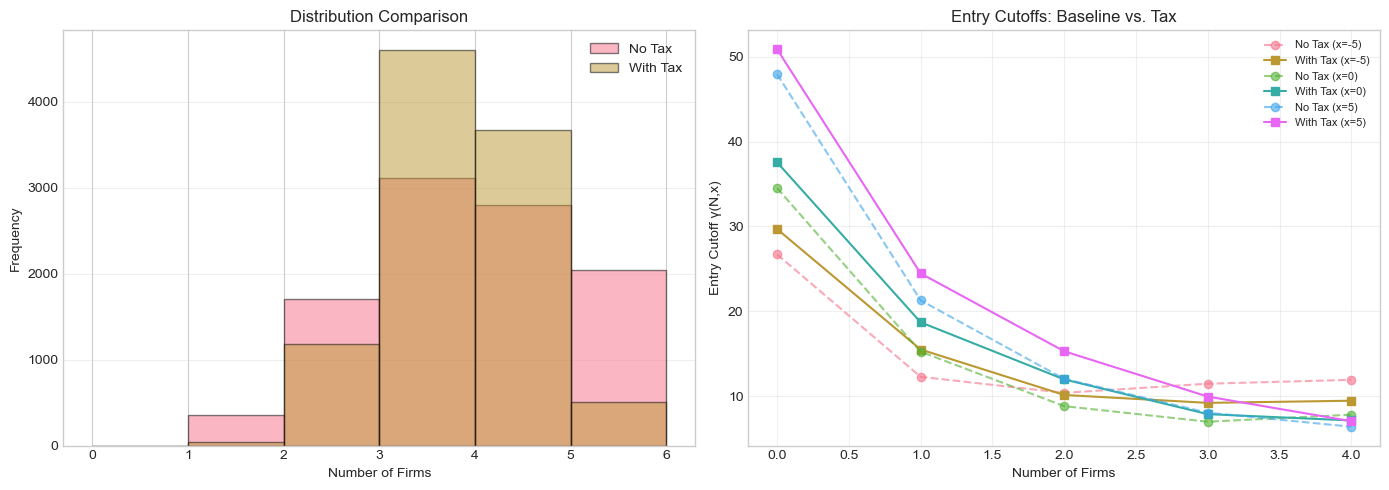



**Answer to Multiple Equilibria Question:**
If there are multiple equilibria, the counterfactual prediction
depends on which equilibrium we select. Different equilibria may
lead to different predictions about the effect of the entry tax.

However, if all initial guesses converge to the same equilibrium
(as we found in Question 5), then we can provide a unique
counterfactual prediction.


In [33]:
print("="*70)
print("Question 8: Entry Tax Counterfactual")
print("="*70)

# Create new game with entry tax
game_tax = DynamicEntryExitGame(gamma=10, sigma_gamma=np.sqrt(5),  # γ + 5
                                 mu=5, sigma_mu=np.sqrt(5))

print("\nSolving equilibrium with 5-unit entry tax...")
print(f"New entry cost mean: γ = {game_tax.gamma}")

converged_tax = game_tax.solve_equilibrium(max_iter=2000, tol=1e-8, verbose=True)

if converged_tax:
    # Simulate with tax
    df_sim_tax = game_tax.simulate_market(N_init=0, x_init=0, T=10000, seed=1995)
    
    avg_firms_tax = df_sim_tax['N'].mean()
    
    print(f"\n\n{'='*70}")
    print("Results Comparison")
    print(f"{'='*70}")
    print(f"\n  Baseline (no tax):")
    print(f"    Average firms: {avg_firms:.3f}")
    print(f"\n  With 5-unit entry tax:")
    print(f"    Average firms: {avg_firms_tax:.3f}")
    print(f"\n  Effect of tax:")
    print(f"    Change: {avg_firms_tax - avg_firms:.3f} firms ({100*(avg_firms_tax - avg_firms)/avg_firms:.1f}%)")
    
    # Compare distributions
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution comparison
    axes[0].hist(df_sim['N'], bins=range(0, 7), alpha=0.5, label='No Tax', edgecolor='black')
    axes[0].hist(df_sim_tax['N'], bins=range(0, 7), alpha=0.5, label='With Tax', edgecolor='black')
    axes[0].set_xlabel('Number of Firms')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Entry cutoff comparison
    for x_val in [-5, 0, 5]:
        N_range = range(0, 5)
        gamma_baseline = [game.gamma_cutoff.get((n, x_val), np.nan) for n in N_range]
        gamma_tax = [game_tax.gamma_cutoff.get((n, x_val), np.nan) for n in N_range]
        axes[1].plot(N_range, gamma_baseline, marker='o', linestyle='--', 
                    label=f'No Tax (x={x_val})', alpha=0.6)
        axes[1].plot(N_range, gamma_tax, marker='s', linestyle='-',
                    label=f'With Tax (x={x_val})')
    axes[1].set_xlabel('Number of Firms')
    axes[1].set_ylabel('Entry Cutoff γ(N,x)')
    axes[1].set_title('Entry Cutoffs: Baseline vs. Tax')
    axes[1].legend(fontsize=8)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"\n\n**Answer to Multiple Equilibria Question:**")
print(f"If there are multiple equilibria, the counterfactual prediction")
print(f"depends on which equilibrium we select. Different equilibria may")
print(f"lead to different predictions about the effect of the entry tax.")
print(f"\nHowever, if all initial guesses converge to the same equilibrium")
print(f"(as we found in Question 5), then we can provide a unique")
print(f"counterfactual prediction.")

## Questions 9-10: BBL Estimation

**Using simulated data from Question 7, estimate $\gamma, \sigma_\gamma^2, \mu, \sigma_\mu^2$ using a BBL-like estimator.**

### BBL Estimation Procedure

Following Bajari, Benkard, and Levin (2007) and Ryan (2024):

#### **Step A: Estimate Reduced-Form Policy Functions**

From the data, estimate:
- $\hat{d}(N_t, x_t)$ = empirical probability that an incumbent stays
- $\hat{e}(N_t, x_t)$ = empirical probability that the entrant enters

These are **frequency estimators** (non-parametric CCPs).

#### **Step B-C: Forward Simulation**

For candidate parameters $(\gamma, \sigma_\gamma, \mu, \sigma_\mu)$:
1. At each state, simulate forward to compute expected PDV
2. Use estimated policy functions to simulate decisions of other players
3. Draw shocks: firms stay if $\Phi\left(\frac{\mu_{it} - \mu}{\sigma_\mu}\right) \leq \hat{d}(N_t, x_t)$
4. Compute $\Lambda(N_t, x_t | \theta)$ = simulated expected PDV for incumbent
5. Compute $\Lambda^E(N_t, x_t | \theta)$ = simulated expected PDV for entrant

**Key BBL Insight**: Under true parameters, the inequality should hold:
$V(s; a^*(s); \theta) \geq V(s; a'(s); \theta), \quad \forall a'(s) \neq a^*(s)$

#### **Step D-F: Minimum Distance Estimation**

Find parameters that match predicted to observed choice probabilities:
$\min_{\theta} \sum_{N_t, x_t} \left[\Phi\left(\frac{\Lambda(N_t,x_t|\theta) - \mu}{\sigma_\mu}\right) - \hat{d}(N_t,x_t)\right]^2 + \left[\Phi\left(\frac{\Lambda^E(N_t,x_t|\theta) - \gamma}{\sigma_\gamma}\right) - \hat{e}(N_t,x_t)\right]^2$